# Smile Detection Using Convolutional Neural Networks

## Dataset: LFW (Labeled Faces in the Wild)



In [13]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
from pathlib import Path
import sys


### **Cell 1:** Import Train and validation Data from the created class train_val

In [3]:
notebook_path = Path.cwd() 

src_path = notebook_path.parent 
sys.path.insert(0, str(src_path))

# Importing TrainVal class
from train_val import TrainVal 
from dataset import LFWDataset

### **Cell 2:** Call the train and validation functions from the created class train_val

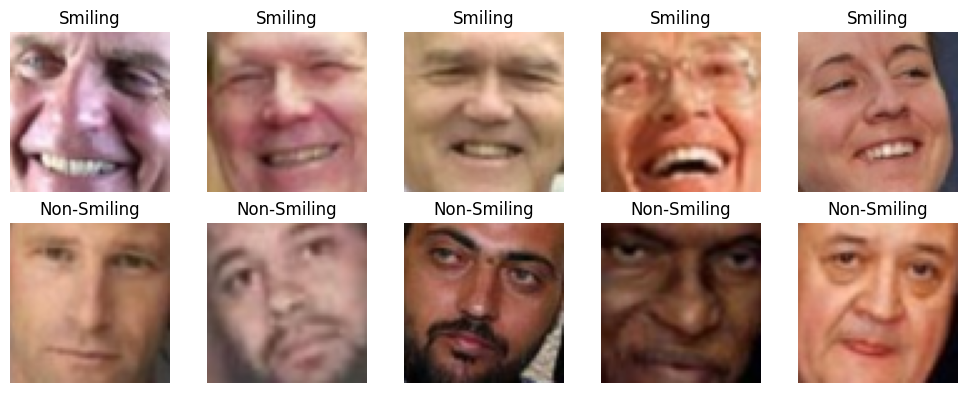

In [4]:
from torchvision import transforms

# 1. Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# 2. Crear el LFWDataset
FACES_FOLDER   = r'C:\Users\santo\OneDrive\Documentos\Neural network\Smile-Detection-Model\lfwcrop_color\faces'
SMILE_FILE     = r'C:\Users\santo\OneDrive\Documentos\Neural network\Smile-Detection-Model\SMILE_list.txt'
NON_SMILE_FILE = r'C:\Users\santo\OneDrive\Documentos\Neural network\Smile-Detection-Model\NON-SMILE_list.txt'

lfw_dataset = LFWDataset(
    faces_folder=FACES_FOLDER,
    smiling_labels_file=SMILE_FILE,
    non_smiling_labels_file=NON_SMILE_FILE,
    transform=transform
)

# 3. Crear objeto TrainVal usando ese dataset
tv = TrainVal(lfw_dataset, val_split=0.15)

# 4. Obtener DataLoaders
train_loader = DataLoader(tv.train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(tv.val_dataset,   batch_size=64, shuffle=False)

# 5. Visualizar ejemplos
tv.visualize_samples()


## Cell 3: Convolutional Neural Network Model for Smile Detection architecture

In [5]:
# CNN Model architecture

class SmileCNN(nn.Module):
    def __init__(self):
        super(SmileCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
# It uses Sigmoid activation in the output layer for binary classification (smiling vs non-smiling).

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SmileCNN().to(device)

print(f"\nModel architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


Model architecture:
SmileCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 4,288,577


### **Cell 4:** Define the Training Function

In [6]:
# training funcion with early stopping

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    return train_losses, val_losses

### **Cell 4:** Define the Evaluation Function

In [7]:
# Evaluate function
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())
            
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs).flatten()
         
    return all_labels, all_outputs

### **Cell 5:** Train the Model

In [19]:
### **Cell 5:** Train the Model
EPOCHS = 50
LEARNING_RATE = 0.01

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting training...\n")
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)



Starting training...



Epoch 1/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


Epoch 1/50, Train Loss: 5.0920, Val Loss: 0.6408


Epoch 2/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


Epoch 2/50, Train Loss: 0.5130, Val Loss: 0.4053


Epoch 3/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.04it/s]


Epoch 3/50, Train Loss: 0.3356, Val Loss: 0.4621


Epoch 4/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


Epoch 4/50, Train Loss: 0.2969, Val Loss: 0.3462


Epoch 5/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


Epoch 5/50, Train Loss: 0.2107, Val Loss: 0.3256


Epoch 6/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


Epoch 6/50, Train Loss: 0.1923, Val Loss: 0.3793


Epoch 7/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


Epoch 7/50, Train Loss: 0.1739, Val Loss: 0.3214


Epoch 8/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.69it/s]


Epoch 8/50, Train Loss: 0.1624, Val Loss: 0.2534


Epoch 9/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


Epoch 9/50, Train Loss: 0.1313, Val Loss: 0.2614


Epoch 10/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


Epoch 10/50, Train Loss: 0.1024, Val Loss: 0.2468


Epoch 11/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Epoch 11/50, Train Loss: 0.0751, Val Loss: 0.2553


Epoch 12/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


Epoch 12/50, Train Loss: 0.0844, Val Loss: 0.1885


Epoch 13/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.59it/s]


Epoch 13/50, Train Loss: 0.0987, Val Loss: 0.3719


Epoch 14/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Epoch 14/50, Train Loss: 0.0690, Val Loss: 0.2906


Epoch 15/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Epoch 15/50, Train Loss: 0.0748, Val Loss: 0.2203


Epoch 16/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


Epoch 16/50, Train Loss: 0.0510, Val Loss: 0.1993


Epoch 17/50 - Validation: 100%|██████████| 3/3 [00:00<00:00, 10.66it/s]

Epoch 17/50, Train Loss: 0.0585, Val Loss: 0.3041
Early stopping!


### **Cell 6:** Training and Validation Loss Plot

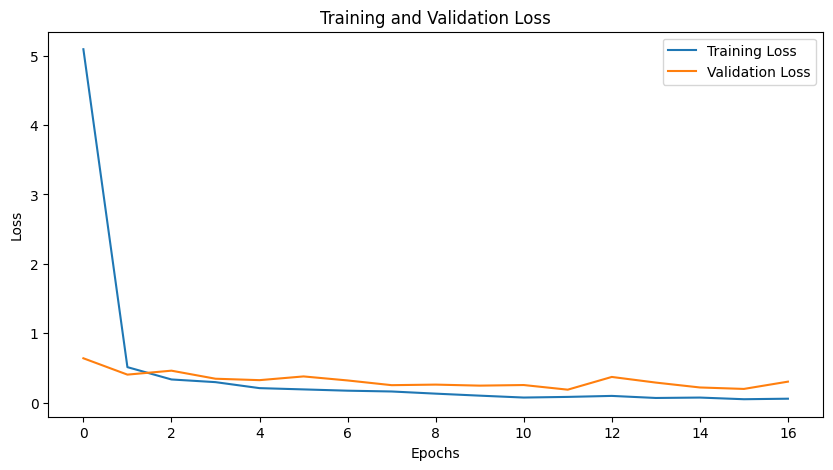


Best model loaded for evaluation.


Classification Report:
              precision    recall  f1-score   support

 Non-Smiling       0.93      0.97      0.95        90
     Smiling       0.97      0.92      0.94        90

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg       0.95      0.94      0.94       180



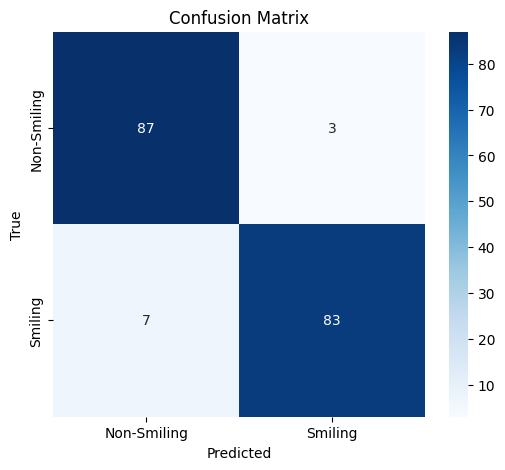

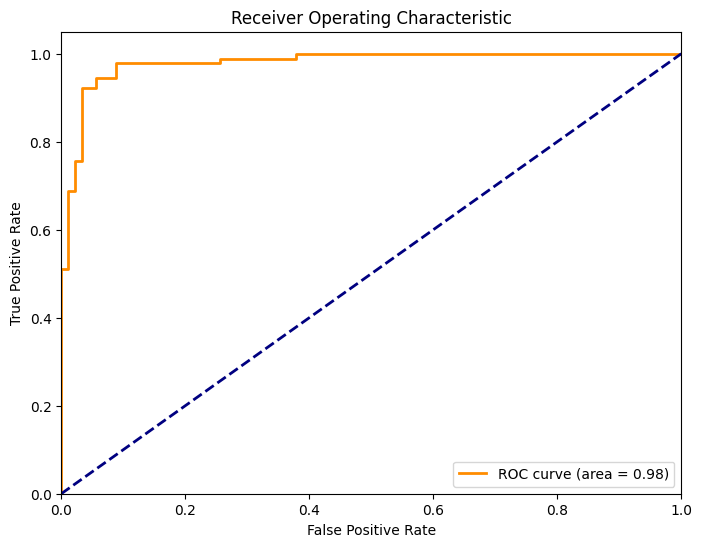

In [ ]:
#Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
print("\nBest model loaded for evaluation.\n")

# Evaluate the model
true_labels, predicted_probs = evaluate_model(model, val_loader)

# Binarize predictions
predicted_labels = (predicted_probs >= 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Non-Smiling', 'Smiling']))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smiling', 'Smiling'], yticklabels=['Non-Smiling', 'Smiling'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()




### **Cell 7:**  Visualize some Predictions

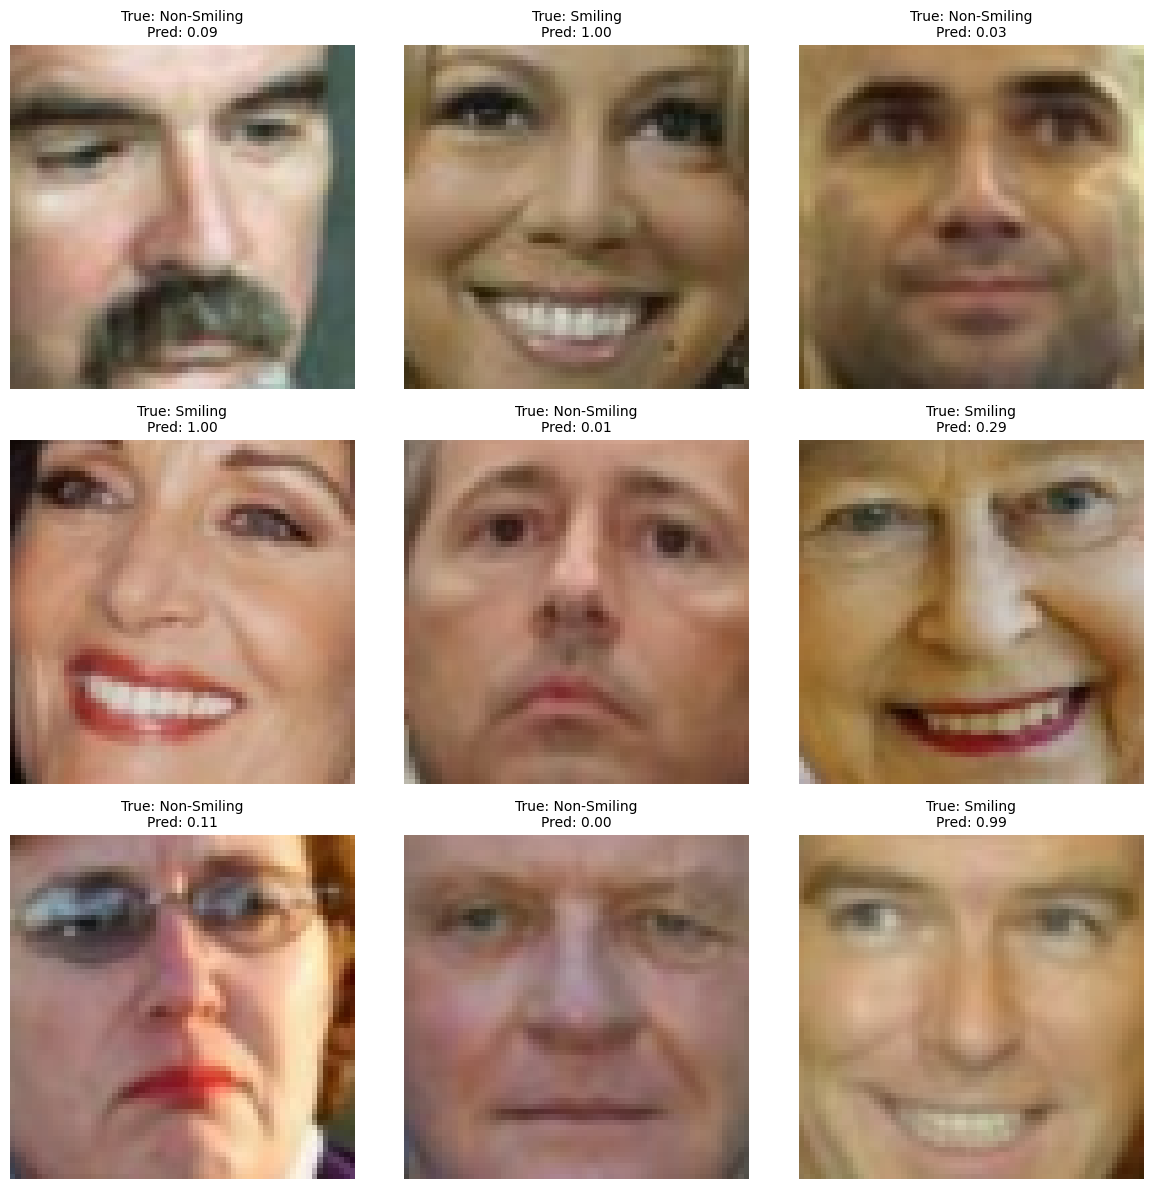

In [15]:
# Visualize predicions using the best_model.pth
def visualizar_predicciones_bestmodel(model_class, model_path, dataloader, num_imagenes, device='cpu'):

    # 1. Crear el modelo desde su clase
    model = model_class().to(device)

    # 2. Cargar los pesos
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. Tomar un batch del dataloader
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)

    # 4. Obtener predicciones
    with torch.no_grad():
        outputs = model(images)            
        probs = outputs.squeeze(1)

        probs = probs.cpu().numpy()

    # 5. Visualización
    num_imagenes = min(num_imagenes, len(images))
    
    cols = math.ceil(math.sqrt(num_imagenes))         
    rows = math.ceil(num_imagenes / cols)             

    plt.figure(figsize=(4 * cols, 4 * rows))

    class_names = {0: "Non-Smiling", 1: "Smiling"}

    for i in range(num_imagenes):
        ax = plt.subplot(rows, cols, i + 1)

        img = images[i].cpu().permute(1, 2, 0)
        true_label = int(labels[i].item())
        pred_prob = float(probs[i])

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"True: {class_names[true_label]}\nPred: {pred_prob:.2f}",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()
    
visualizar_predicciones_bestmodel(SmileCNN, 'best_model.pth', val_loader, num_imagenes=9)